## Machine Learning

[walter.daelemans@uantwerpen.be](mailto:walter.daelemans@uantwerpen.be)

### Decision Trees, k-nn, SVM, NN on Titanic

In [2]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

# Remember: 
# A pipeline consist of a series of transformers (fit, transform), 
# last one an estimator with fit and predict
# train -> fit, transform, fit, transform ... fit -> Model 
# test -> fit, transform, fit, transform ... -> Model -> Predict

#### Titanic Data

In [4]:
titanic = pd.read_csv('data/titanic.csv')
X = titanic.drop(columns=['Survived'])
y = titanic.Survived

In [5]:
titanic.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
731,732,0,3,"Hassan, Mr. Houssein G N",male,11.0,0,0,2699,18.7875,NaN,C
589,590,0,3,"Murdlin, Mr. Joseph",male,NaN,0,0,A./5. 3235,8.0500,NaN,S
73,74,0,3,"Chronopoulos, Mr. Apostolos",male,26.0,1,0,2680,14.4542,NaN,C


## Logistic Regression

In [7]:
ohe = OneHotEncoder()
scaler = StandardScaler() 
imputer = KNNImputer()

numeric_pipe = make_pipeline(imputer, scaler)

ct = make_column_transformer(
    (ohe, ['Sex']), 
    (numeric_pipe, ['Pclass', 'Age']),
    remainder='drop') 

logreg = LogisticRegression(random_state=42)
pipe = make_pipeline(ct, logreg)
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(), ['Sex']),
                                                 ('pipeline',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Pclass', 'Age'])])),
                ('logisticregression', LogisticRegression(random_state=42))])

In [8]:
from sklearn.model_selection import cross_val_score

For the comparisons we are doing here 10 train-test partitions which allows us to compute a standard deviation and an average for comparison.


In [10]:
lr_scores = cross_val_score(pipe, X, y, cv=10, scoring='f1_macro')
lr_scores

array([0.78961039, 0.77516288, 0.72775306, 0.82718447, 0.79183992,
       0.75919913, 0.76659765, 0.72344633, 0.78327922, 0.78582888])

In [11]:
print(f"Mean {lr_scores.mean()}, Std {lr_scores.std()}")

Mean 0.772990192192257, Std 0.029284858646532522


## Decision Tree Learning

We transform the train dataset into a decision tree with nodes and connections.

- Nodes are tests
- Nodes have decisions (outputs) and are more or less homogeneous

- Decision trees have an advantage in **explainability** but usually perform less well than other methods


Algorithm:

Given a set of examples X
- If X contains one or more cases all belonging to the same class C, then the decision tree for X is a leaf node with category C.
- If X contains different classes then 
    - Choose a feature, and partition X into subsets that have the same value for the feature chosen. The decision tree consists of a node containing the feature name, and a branch for each value leading to a subset.
    - Apply the procedure recursively to subsets created this way. 
    
    
How to select a feature to split on?

Choose the test (feature) that partitions the data in such a way that it maximizes homogeneity of the resulting subsets. 
Quantified by means of for example information entropy (highest reduction in information entropy). 



In [14]:
from sklearn.tree import DecisionTreeClassifier
#from sklearn import tree 
from sklearn.tree import plot_tree

In [15]:
# We do manually here what we normally do with a column transformer because we want
# interpretable values in the tree (i.e. no one hot encoding and scaling

dt = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)

X_dt = titanic[['Sex', 'Age', 'Pclass']].copy()
X_dt['Sex'] = X_dt['Sex'].replace({'male': 0, 'female': 1})
X_dt['Age'] = imputer.fit_transform(X_dt[['Age']])
y_dt = titanic['Survived']

dt.fit(X_dt, y_dt)


DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)

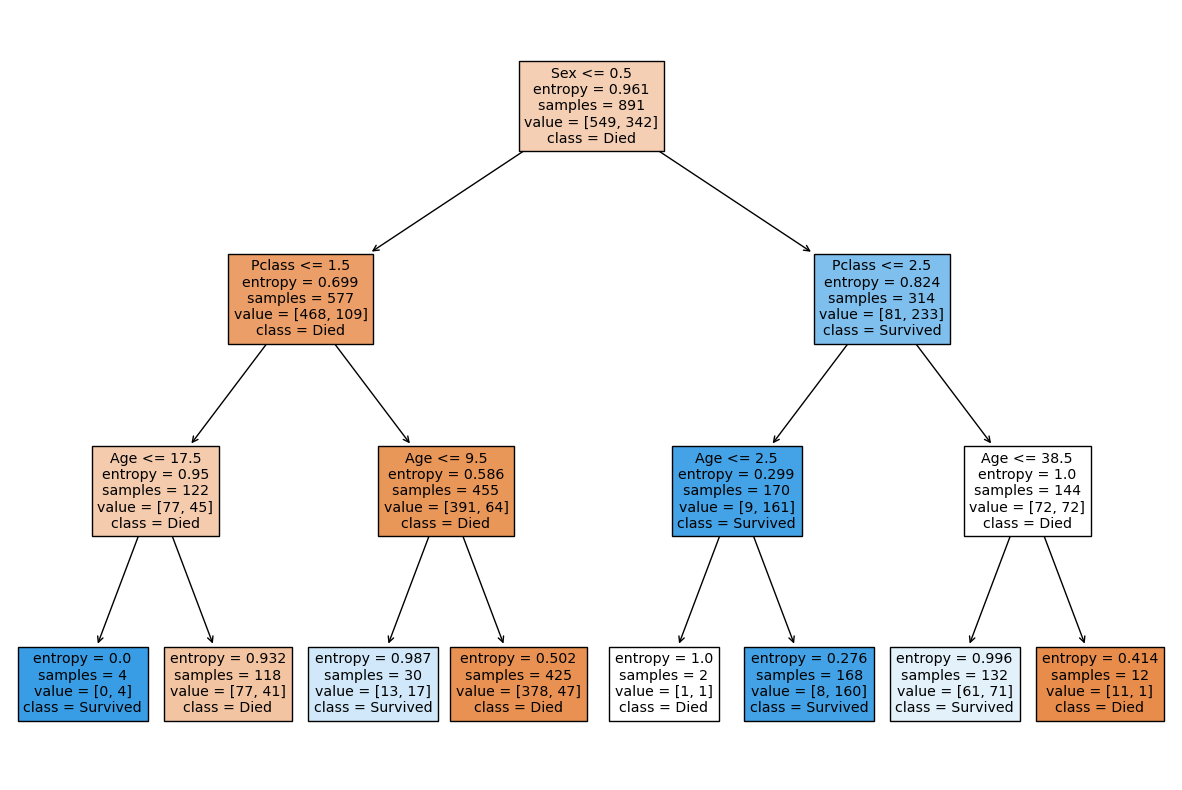

In [16]:
# Plot the decision tree

plt.figure(figsize=(15, 10))
plot_tree(dt, feature_names=['Sex', 'Age', 'Pclass'], class_names=['Died', 'Survived'], filled=True)
plt.show()

# Note: the fact that the same features are tested at the same level of the tree is 
# accidental: use depth > 3 to see this (repeated features in a different order).

In [17]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)
pipe = make_pipeline(ct, dt)
dt_scores = cross_val_score(pipe, X, y, cv=10, scoring='f1_macro')
dt_scores

array([0.79791309, 0.79183992, 0.74202899, 0.87113334, 0.81164021,
       0.73812526, 0.73812526, 0.7337986 , 0.82049213, 0.78256397])

In [18]:
print(f"Mean {dt_scores.mean()}, Std {dt_scores.std()}")

Mean 0.78276607797423, Std 0.0429190873431635


## Random Forest

The Random Forest Classifier is actually considered an ensemble method rather than a single machine learning algorithm. It builds multiple decision trees and combines their predictions to improve accuracy and reduce overfitting.

Multiple decision trees are generated during training on random subsets of the data. Each of those trees votes on the class of an input and the majority vote is returned.

This reduces the likelihood of errors since individual trees may overfit, but the ensemble tends to generalize better by canceling out errors by individual descision trees.

In [21]:
from sklearn.ensemble import RandomForestClassifier

In [22]:
rf = RandomForestClassifier(random_state=42, n_estimators=100)

In [23]:
pipe = make_pipeline(ct, rf)
rf_scores = cross_val_score(pipe, X, y, cv=10, scoring='f1_macro')
rf_scores

array([0.77123746, 0.79655775, 0.74202899, 0.82249701, 0.85873016,
       0.8182437 , 0.80962567, 0.79887006, 0.84030366, 0.76455026])

In [24]:
print(f"Mean {rf_scores.mean()}, Std {rf_scores.std()}")

Mean 0.8022644712980618, Std 0.03378116571688682


## k-NN (Memory-Based Learning, instance-based learning)

In [26]:
from sklearn.neighbors import KNeighborsClassifier

In [27]:
knn = KNeighborsClassifier()

In [28]:
pipe = make_pipeline(ct, knn)
knn_scores = cross_val_score(pipe, X, y, cv=10, scoring='f1_macro')
knn_scores

array([0.77673325, 0.80735931, 0.71746032, 0.84770304, 0.87227658,
       0.79116632, 0.82049213, 0.7954023 , 0.82675195, 0.78327922])

In [29]:
print(f"Mean {knn_scores.mean()}, Std {knn_scores.std()}")

Mean 0.8038624424116533, Std 0.040339746121362166


In [30]:
from sklearn.model_selection import validation_curve

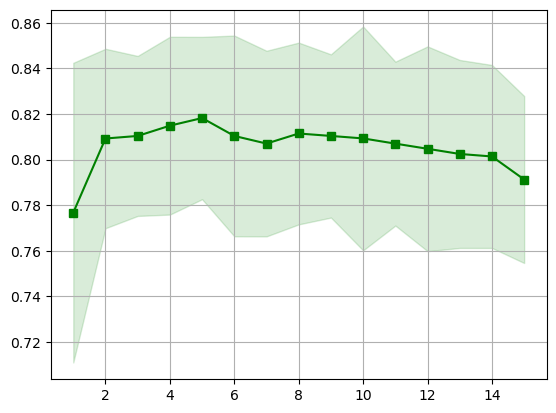

In [31]:
# Investigate the effect of k 

param_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
train_scores, test_scores = validation_curve(estimator=pipe, X=X, y=y, \
                                             param_name= 'kneighborsclassifier__n_neighbors', param_range=param_range, cv=10)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, test_mean, color='green', marker='s')
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.show()


## Support Vector Machines

<img src=figures/svm1.png>

- "margin" is distance between separating hyperplane and training examples closest to the hyperplane (support vectors)
- Max margin:
    - construct parallel hyperplanes (positive and negative)
    - quadratic programming
- Soft margin classification (slack variable to control width of the margin (C parameter: small = wide margin and more violations, large = narrow margin and fewer violations)
    - influences bias-variance trade-off

In [33]:
from sklearn.svm import SVC

In [34]:
svm = SVC()
pipe = make_pipeline(ct, svm)

In [35]:
svm_scores = cross_val_score(pipe, X, y, cv=10, scoring='f1_macro')
svm_scores

array([0.78178879, 0.83143939, 0.72775306, 0.86983114, 0.81164021,
       0.7337986 , 0.75250278, 0.7337986 , 0.81573499, 0.79882994])

In [36]:
print(f"Mean {svm_scores.mean()}, Std {svm_scores.std()}")

Mean 0.7857117518830872, Std 0.045585349221867306


### Kernels

- How to solve non-linear problems?
    - Be flexible (e.g. soft margin)
    - "Add" features (e.g. kernel function)
    - Use a non-linear learner (e.g. Deep Neural Networks)
- Create nonlinear combinations of the original features and project them to a higher-dimensional space with a mapping function $\theta$
    - Example: $\theta(x_1, x_2) = (z_1, z_2, z_3) = (x_1, x_2, x_1^2+x_2^2)$
    - train a linear SVM on the data in this new (linearly separable) space
    - "kernel trick" makes this computationally feasible
    - RBF kernel is a similarity function between pairs of instances


Next we investigate what the effect is of different hyperparameters on the f1-score. This is only to get some insight, it is of course better to systematically investigate the *combinations* of parameters in a GridsearchCV or RandomSearchCV. 

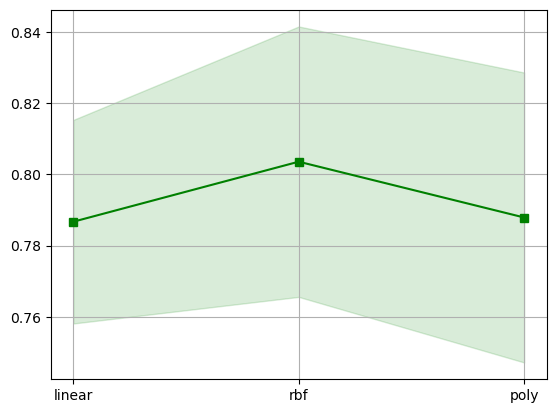

In [39]:
# Effect of kernel

param_range = ['linear', 'rbf', 'poly']
train_scores, test_scores = validation_curve(estimator=pipe, X=X, y=y, \
                                             param_name= 'svc__kernel', param_range=param_range, cv=10)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, test_mean, color='green', marker='s')
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.show()

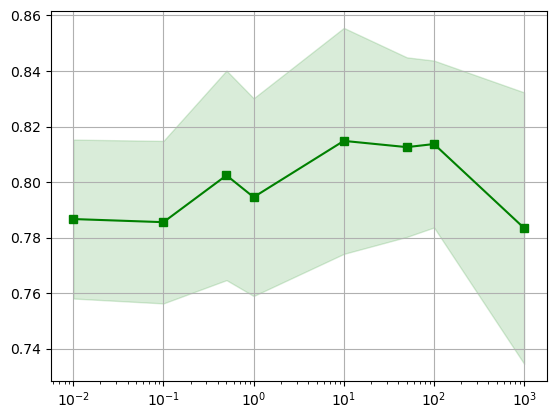

In [40]:
# Effect of gamma

# Gamma (with rbf kernel) controls how closely the algorithm tries to fit the training data (higher = closer)
param_range = [0.01, 0.1, 0.5, 1.0, 10.0, 50.0, 100.0, 1000.0]

train_scores, test_scores = validation_curve(estimator=pipe, X=X, y=y, \
                                             param_name= 'svc__gamma', param_range=param_range, cv=10)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, test_mean, color='green', marker='s')
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.show()

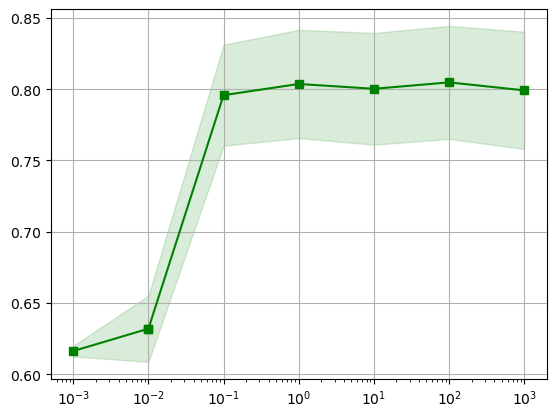

In [41]:
# C controls the 'softness' of the margin in SVMs
param_range = [0.001, 0.01, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
train_scores, test_scores = validation_curve(estimator=pipe, X=X, y=y, \
                                             param_name= 'svc__C', param_range=param_range, cv=10)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, test_mean, color='green', marker='s')
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.show()

## Multi-Layer Perceptron

In [43]:
from sklearn.neural_network import MLPClassifier

In [44]:
nn = MLPClassifier(max_iter=1000, hidden_layer_sizes=(500))
pipe = make_pipeline(ct, nn)

In [45]:
nn_scores = cross_val_score(pipe, X, y, cv=10, scoring='f1_macro')
nn_scores

array([0.66769231, 0.71340749, 0.74202899, 0.88227513, 0.80545197,
       0.79655775, 0.74202899, 0.7337986 , 0.8322459 , 0.75919913])

In [46]:
print(f"Mean {nn_scores.mean()}, Std {nn_scores.std()}")

Mean 0.7674686273080381, Std 0.05919448177788613


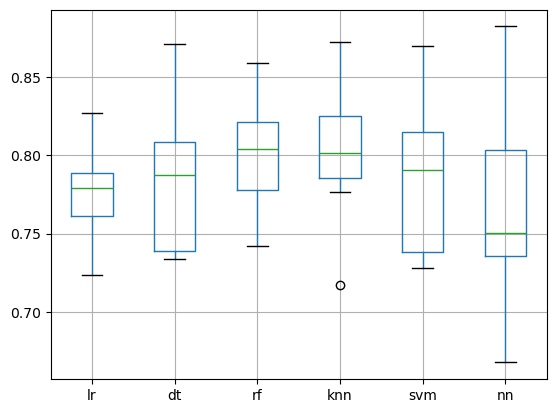

In [47]:
# Compare the scores for the different classifiers

d = {'lr': lr_scores, 'dt': dt_scores, 'rf': rf_scores, 'knn': knn_scores, 'svm': svm_scores, 'nn': nn_scores}
results = pd.DataFrame(d)
results.boxplot();

### Gridsearching algorithms and parameters at the same time

It is possible to optimize different algorithms and their associated parameters in one grid, like in the following example.

In [49]:
# Define a pipeline with a placeholder for the estimator

from sklearn.pipeline import Pipeline
# Didn't find a way to do this with make_pipeline

pipe = Pipeline([
    ('preprocessor', ct),  
    ('classifier', SVC())  # Named classifier to match the grid, can be any
])


# Define a parameter grid that includes different algorithms and their hyperparameters
grid = [
    {
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [10, 50, 100],
        'classifier__max_depth': [None, 10, 20]
    },
    {
        'classifier': [SVC()],
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf']
    },
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [1, 3, 5, 7, 9],
        'classifier__weights': ['uniform', 'distance']
    }
]

In [50]:
# Use GridSearchCV to search over the pipeline's parameters
gs = GridSearchCV(pipe, grid, cv=5, verbose=1)
gs.fit(X, y)

# Get the best model and parameters
print("Best model:", gs.best_estimator_)
print("Best parameters:", gs.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(), ['Sex']),
                                                 ('pipeline',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Pclass', 'Age'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=20, n_estimators=50))])
Best parameters: {'classifier': RandomForestClassifier(max_depth=20, n_estimators=50), 'classifier__max_depth': 20, 'classifier__n_estimators': 50}


In [51]:
gs.best_score_

0.815956311593748

In [52]:
pd.set_option('display.max_colwidth', None) 
# reset with pd.reset_option('display.max_colwidth')
pd.DataFrame(data=gs.cv_results_).sort_values(by='rank_test_score')[['params', 'mean_test_score']]

,params,mean_test_score
7,"{'classifier': RandomForestClassifier(max_depth=20, n_estimators=50), 'classifier__max_depth': 20, 'classifier__n_estimators': 50}",0.815956
2,"{'classifier': RandomForestClassifier(max_depth=20, n_estimators=50), 'classifier__max_depth': None, 'classifier__n_estimators': 100}",0.810345
6,"{'classifier': RandomForestClassifier(max_depth=20, n_estimators=50), 'classifier__max_depth': 20, 'classifier__n_estimators': 10}",0.810332
5,"{'classifier': RandomForestClassifier(max_depth=20, n_estimators=50), 'classifier__max_depth': 10, 'classifier__n_estimators': 100}",0.808141
24,"{'classifier': KNeighborsClassifier(), 'classifier__n_neighbors': 9, 'classifier__weights': 'distance'}",0.808129
3,"{'classifier': RandomForestClassifier(max_depth=20, n_estimators=50), 'classifier__max_depth': 10, 'classifier__n_estimators': 10}",0.808097
1,"{'classifier': RandomForestClassifier(max_depth=20, n_estimators=50), 'classifier__max_depth': None, 'classifier__n_estimators': 50}",0.807011
22,"{'classifier': KNeighborsClassifier(), 'classifier__n_neighbors': 7, 'classifier__weights': 'distance'}",0.807005
4,"{'classifier': RandomForestClassifier(max_depth=20, n_estimators=50), 'classifier__max_depth': 10, 'classifier__n_estimators': 50}",0.803647
20,"{'classifier': KNeighborsClassifier(), 'classifier__n_neighbors': 5, 'classifier__weights': 'distance'}",0.802511


We see that in general, the RandomForestClassifier gives the best results with many different hyperparameter settings.